<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">
    Être ou ne pas être ?
</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">
    Un problème de classification binaire sur des données médicales artificelles
<br/>

---

# Membres du groupe

**Minimum 2, Maximum 3**

<span style="color:red">
    Répondre ci-dessous
</span>

* Yilmaz, Mikail
* Bejenaru, Ruslan
* Taguengayte, Lina

# Présentation du challenge

## La question principale de ce challenge est : 

* Comment prédire la survie d'un·e patient·e compte tenu de son dossier médical ? 
    
* Plus précisément, vous devrez prédire la survie des patient·e·s pendant leur séjour à l'hôpital
 
Chaque jour, le personnel soignant collecte de nombreuses informations sur les patient·e·s en posant des questions et en utilisant des outils de mesure (stéthoscope, analyse de sang, capteurs, etc.). Ces données sont très utiles pour surveiller l'état de santé, diagnostiquer et choisir les traitements.

Elles peuvent également être utilisées pour l'analyse statistique prédictive.

## Données

L'ensemble de données contient des informations sur 80'000 patient·e·s, représentés par des variables (descripteurs) catégorielles, binaires et numériques. Ces variables sont, par exemple, l'âge, le sexe, l'origine ethnique, l'état matrimonial, ainsi que des données médicales telles que la tension artérielle ou le taux de glucose. Il y a un total de 342 variables.

La classe (étiquette ou label) à prédire est une variable binaire indiquant si la·le patient·e est décédé·e ou non pendant son séjour à l'hôpital. Heureusement, la plupart survivent :

![](img/tobe.png)

## Tâche

La tâche consiste à créer un modèle capable d'apprendre à partir des données et de faire des prédictions (apprentissage supervisé). Chaque instance (patient·e) possède une variable indiquant si elle·il est décédé·e ou non pendant son séjour à l'hôpital.

Références et crédit :

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

## Instructions

Le but de ce TP est de travailler sur un challenge de prédiction de la mortalité.

Le lien vers le challenge :
https://competitions.codalab.org/competitions/30715

* **Étape 1 :** S'enregistrer sur https://competitions.codalab.org
* **Étape 2:** Téléchargez le jeu de données à partir de la [page](https://competitions.codalab.org/competitions/30715#participate-get_starting_kit) "Participate > Files > Public Data". Placez le dossier "public_data" dans le même dossier que celui contenant ce notebook.
* **Étape 3:** Parcourez ce notebook. Vous devrez lire, exécuter, **coder vos propres méthodes** et **répondre aux questions**. Utilisez la cellule ***code*** pour le codage et la cellule ***markdown*** pour répondre aux questions.

## Évaluation du projet

* **4 points** pour la partie compréhension et analyse exploratoire
    
* **4 points** pour un code propre et bien documenté

* **4 points** pour la qualité du modèle (sélection du modèle, sélection des hyperparamètres)

* **4 points** pour une bonne évaluation des performances du modèle

* **4 points** pour l'originalité et la complétude de la solution 

* **1 point bonus** pour l'équipe gagnante du challenge

### FAQ

* Soumettre uniquement le notebook sur eCampus

* La partie texte (explications, résultats, problèmes, sans le code) ne doit pas dépasser 3 pages A4 11pt (< 1500 mots)

# Challenge

Module particulier requis : `imblearn` (à installer avec `conda` ou `pip`)

* `conda install -c conda-forge imbalanced-learn`

* `pip install imbalanced-learn`

In [1]:
from datetime import datetime
from pathlib import Path
from zipfile import ZipFile

import imblearn
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
)

from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from scipy.stats import sem

from numpy import mean
from numpy import std

In [2]:
%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.4g}".format

## 1. Compréhension du problème

### Expliquez brièvement la tâche avec vos mots

<span style="color:red">
    Répondre ci-dessous
</span>

Il s'agit de prédire la mortalité des patients présents à l'hôpital tout en ayant à notre disposition des descripteurs qui permettent d'établir des corrélations avec l'état de santé d'anciens patients, la gravité (donc leur mort potentielle), ainsi que tous les détails de leur hospitalisation afin de corréler ces données afin de prédire si les patients hospitalisés vont mourir ou non. La tâche que nous allons réaliser est une classification et nous avons 2 classes à prédire.

### Métrique utilisée

Pourquoi la métrique utilisée ici est la [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) plutôt que simplement l'[`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) ?

<span style="color:red">
    Répondre ci-dessous
</span>

`accuracy_score` renvoie le pourcentage de labels prédit correctement. La formule est : tp+tn/(tp+tn+fp+fn) et ne fonctionne pas très bien sur des classes désiquilibrées. 

`balanced_accuracy_score` renvoie la précision moyenne par classe. La formule est: TPR+TNR/2

avec TPR = tp/(tp+fn)

TNR = tn/(tn+fp)

## 2. Chargement des données

In [3]:
DATA = Path(
    "~/Desktop/mika/public_dat"
).expanduser()

# DATA = Path("public_data")

PRED_PATH = Path("Submissions")

DROP_VARS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

In [4]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_df.drop(columns=DROP_VARS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [5]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0


C'est **l'ensemble d'entrainement**. Cela signifie que vous avez accès aux étiquettes et que vous pouvez l'utiliser comme vous le souhaitez pour préparer votre modèle.

Plus tard, vous ferez en sorte que votre modèle tire des prédictions de **l'ensemble de test** afin de les téléverser sur Codalab et d'obtenir un score sur des données non vues lors de l'entrainement des modèles.

In [6]:
# Load test set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_test_df.drop(columns=DROP_VARS, inplace=True)

## 3. Analyse exploratoire

#### Types des variables

In [7]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64

#### Distribution de la variable cible

In [8]:
ys.describe()

count     8e+04
mean    0.03496
std      0.1837
min           0
25%           0
50%           0
75%           0
max           1
dtype: float64

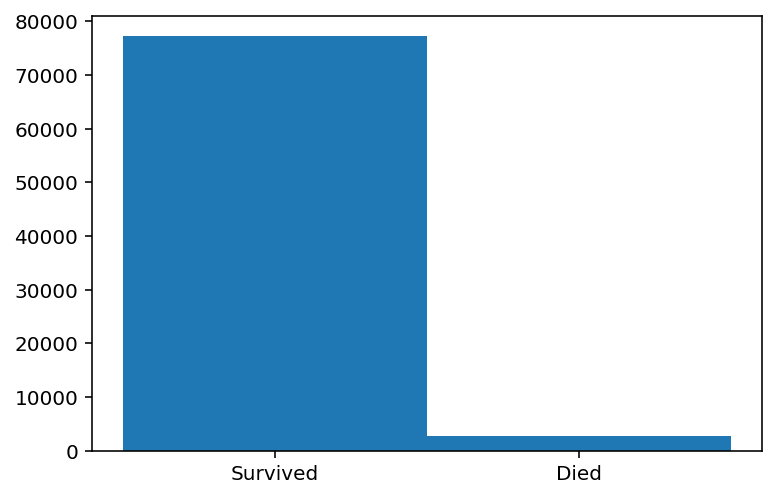

In [9]:
ys.hist(bins=2, grid=False, align="left")
plt.xticks([0, 0.5], ["Survived", "Died"])
# plt.savefig("img/tobe.png", dpi=300)
plt.show()

### Code : Produire les graphiques suivants

* Diagrammes à barres de certaines variables catégorielles (par exemple "LANGUAGE", "MARITAL_STATUS")

* Montrez la corrélation entre certaines variables et la variable cible y

* Un autre graphique ou toute analyse exploratoire à laquelle vous pouvez penser

Exemple

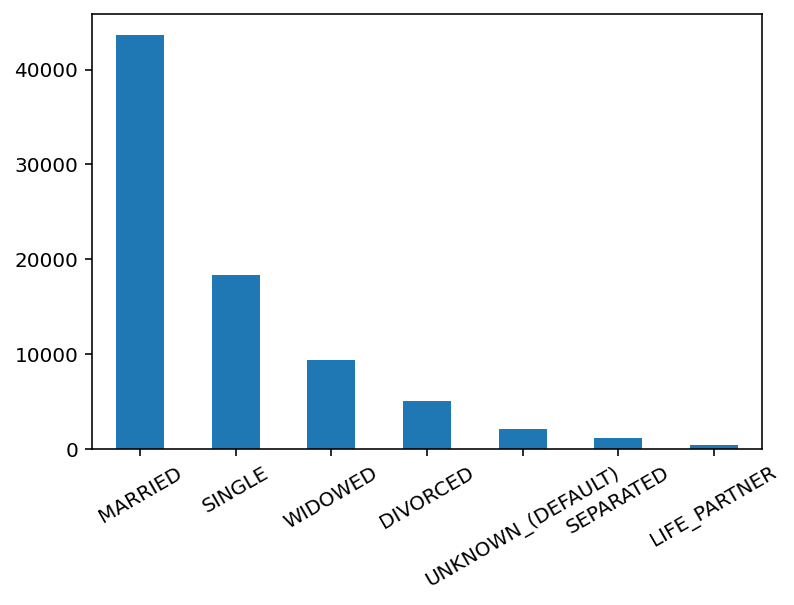

In [10]:
x_marital_cnts = x_df["MARITAL_STATUS"].value_counts()
x_marital_cnts.plot.bar(rot=30)
plt.show()

<span style="color:red">
    Répondre ci-dessous
</span>


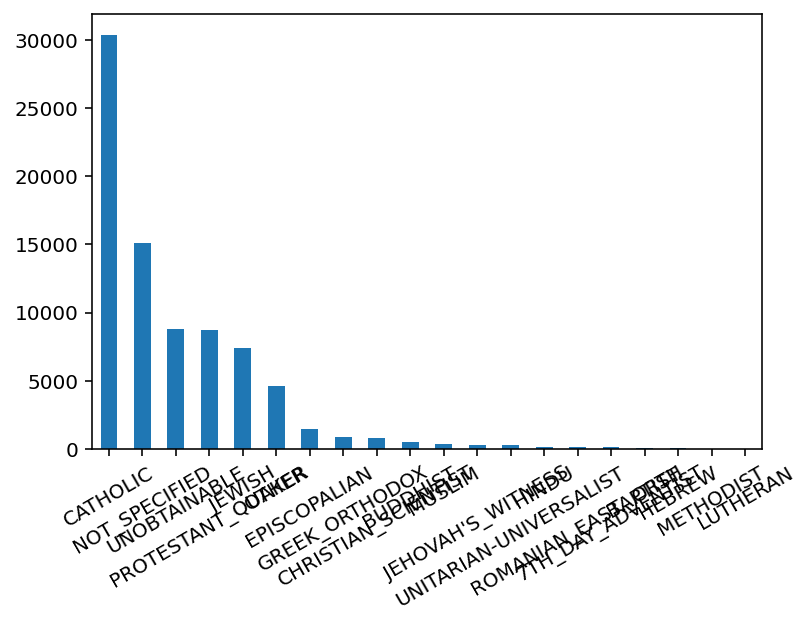

In [11]:
# TODO: Bar plot of another variable
def plot_categoricals(column):
    """ plots an histogram for a given categorical variable """
    x_cnts = x_df[column].value_counts()
    x_cnts.plot.bar(rot=30)
    plt.show()
    
plot_categoricals("RELIGION")

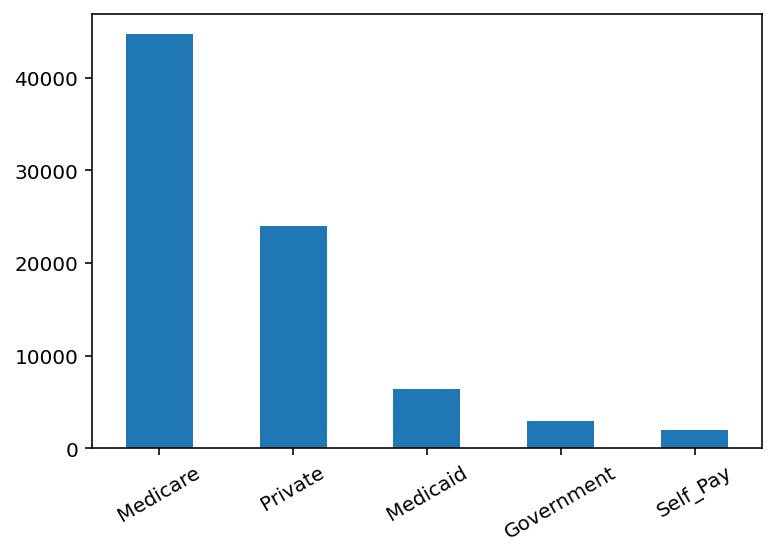

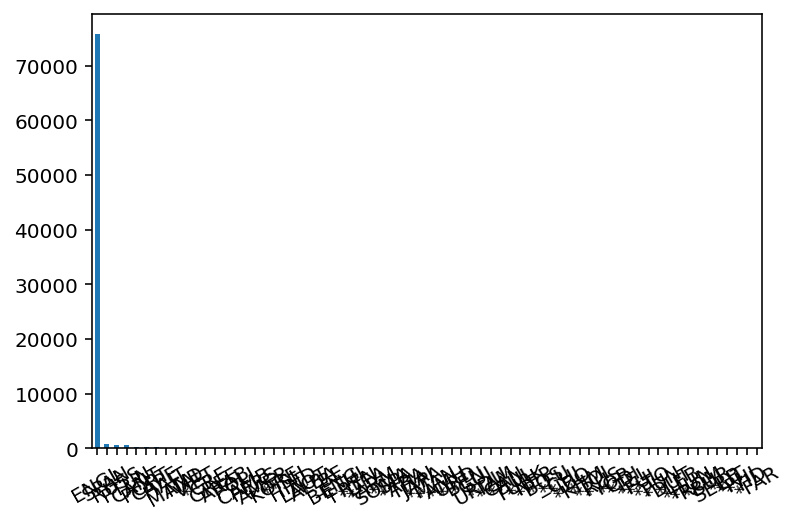

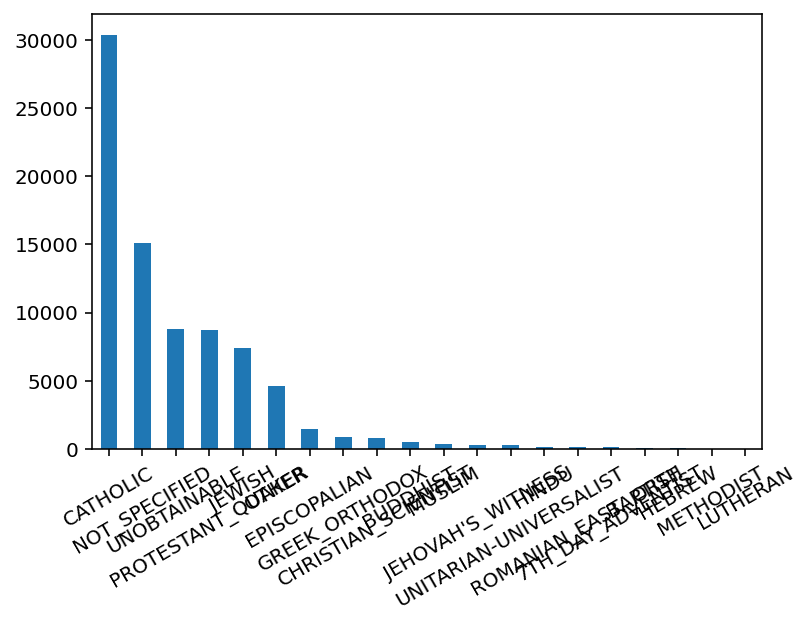

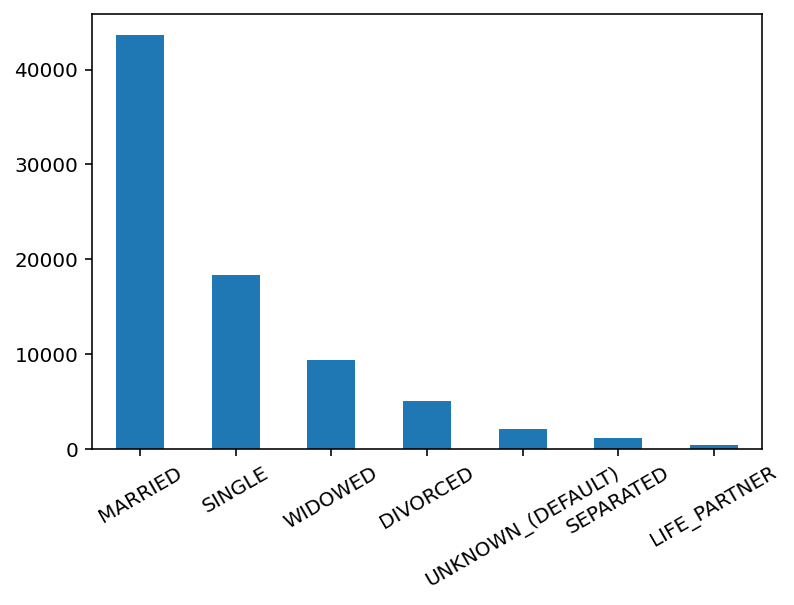

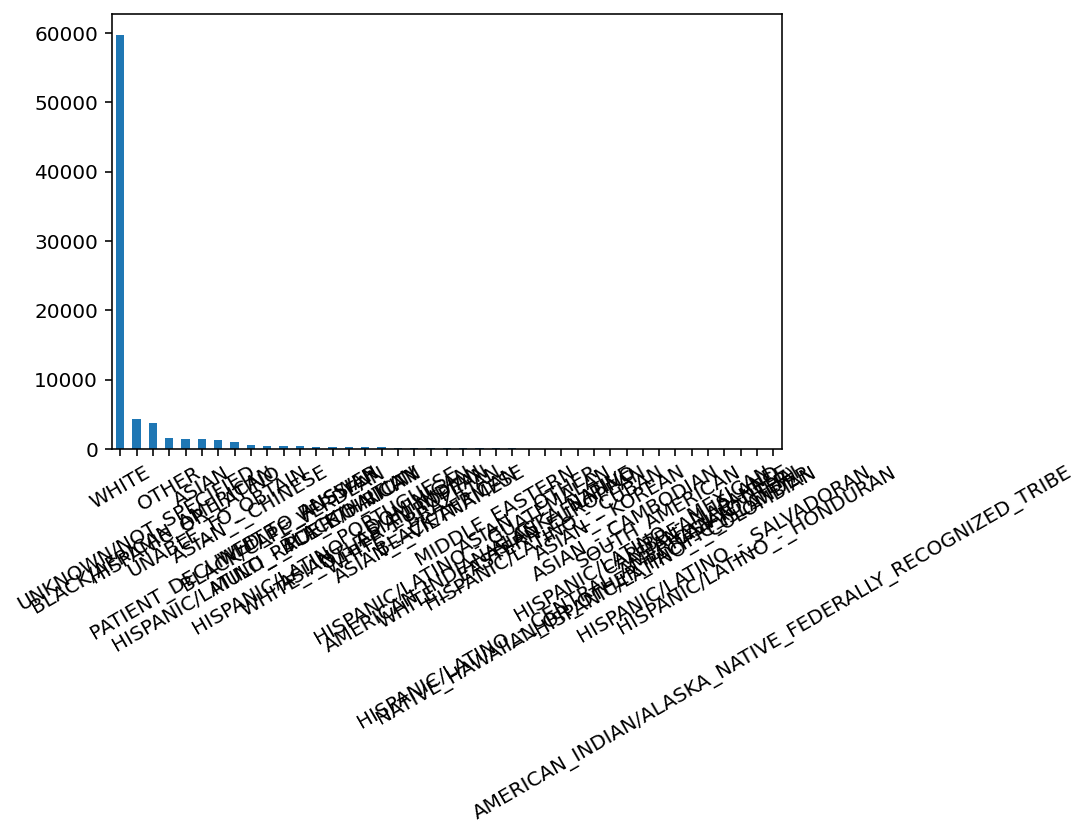

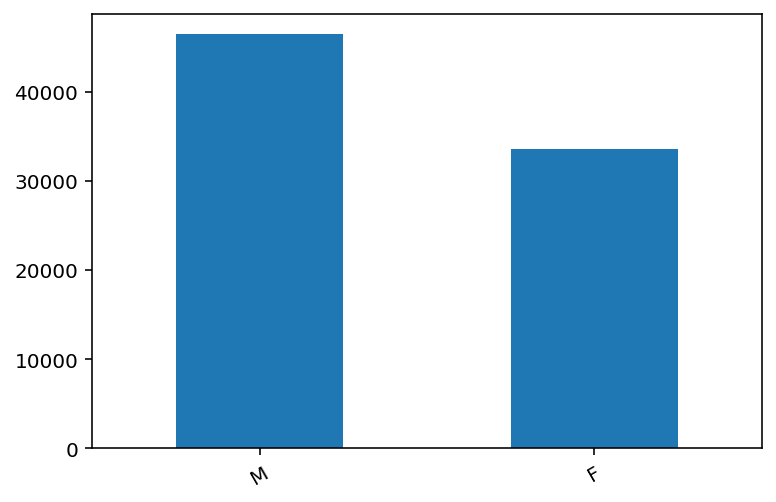

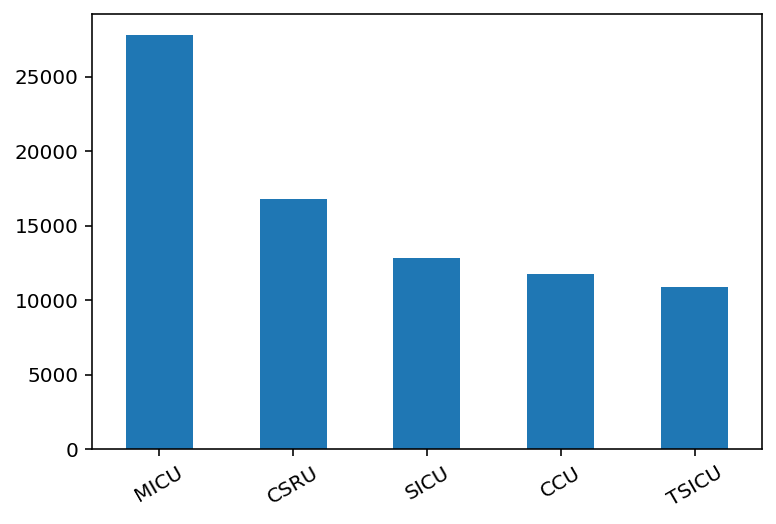

In [12]:
for i in x_df.columns:
    if x_df[i].dtype.kind not in 'biufc':
        plot_categoricals(i)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe5ab1b9ca0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe5ab1af3a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe5ab1b9940>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe5ab1afa60>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe5ab1afdc0>],
 'means': []}

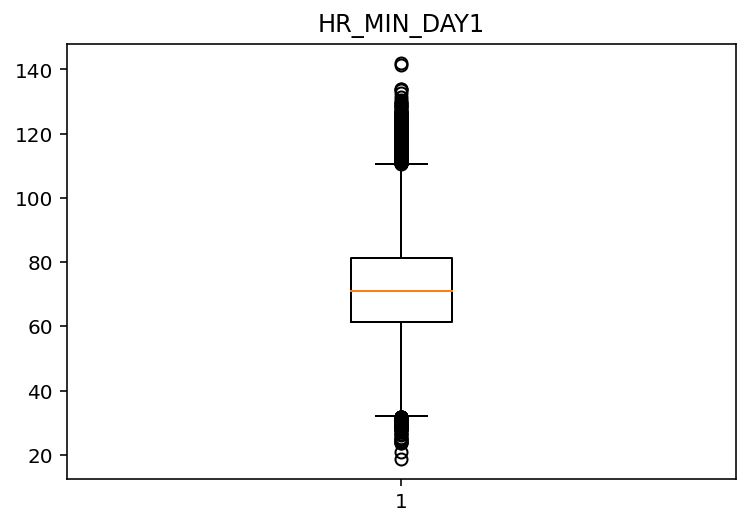

In [13]:
fig1, ax1 = plt.subplots()
ax1.set_title('HR_MIN_DAY1')
ax1.boxplot(x_df["HR_MIN_DAY1"])

#### Corrélations

<AxesSubplot:>

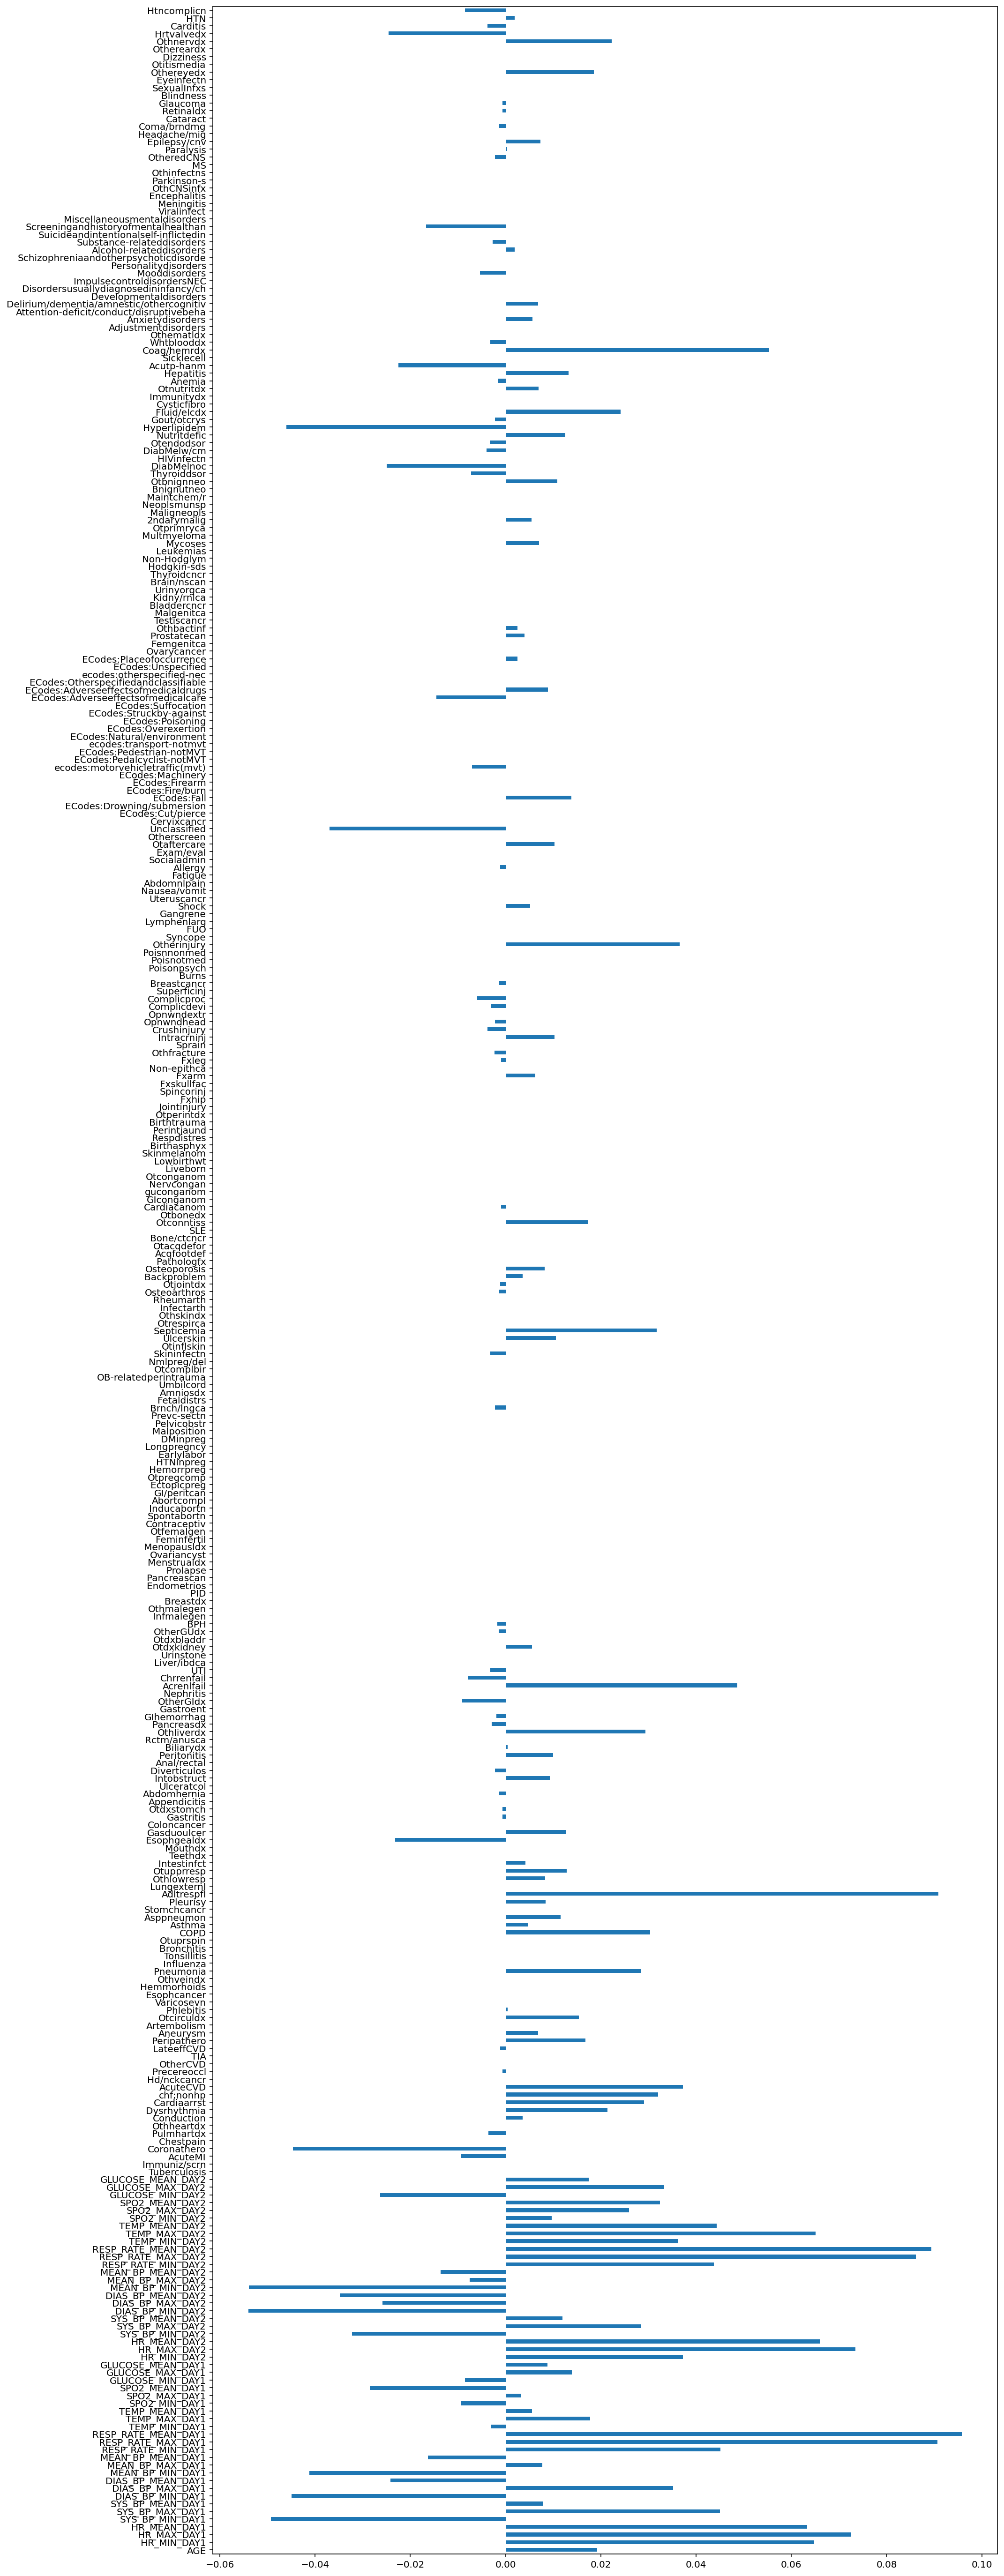

In [14]:
# TODO: Bar plot of the variables most correlated with y

corr_target = x_df.corrwith(ys)
corr_target.sort_values(ascending = False)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15,50)
corr_target.plot.barh()


Astuce :

* Utilisez un graphique avec des barres horizontales `barh` (pour visualiser les valeurs positives et négatives)

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
   
</span>

#### Autres graphiques ou résultats d'une analyse exploratoire

In [15]:
threshold = 0.06
variables_to_keep = corr_target[abs(corr_target) > threshold]
coeff_variables = len(variables_to_keep)/len(corr_target)*100

print("Pourcentage des variables corrélées à plus de %3f : %2f pour cent" % (threshold, coeff_variables))

Pourcentage des variables corrélées à plus de 0.060000 : 3.333333 pour cent


In [16]:
corr_target.describe()

count         157
mean     0.008195
std       0.02778
min      -0.05402
25%     -0.003228
50%      0.003589
75%       0.01729
max       0.09577
dtype: float64

Lecture: On observe que la variable HR_MAX_DAY1 est corrélée a 5% à notre cible prédicitve.

4,24% des variables numériques ont une corrélation supérieur à 5% à la variable cible.

3,33% des variables numériques ont une corrélation supérieur à 6% à la variable cible.

Les corrélations de la valeur minimum : -5,4% jusqu'à ma valeur maximum : 9,5%

La moyenne des corrélations sont de 0,81%

Une corrélation négative entre deux variables indique que les valeurs d'une variable tendent à augmenter lorsque celles de l'autre variable diminuent.

à contrario nne corrélation positive entre deux variables indique que les valeurs de l'une variable tendent à augmenter lorsque celles de l'autre variable augmentent.

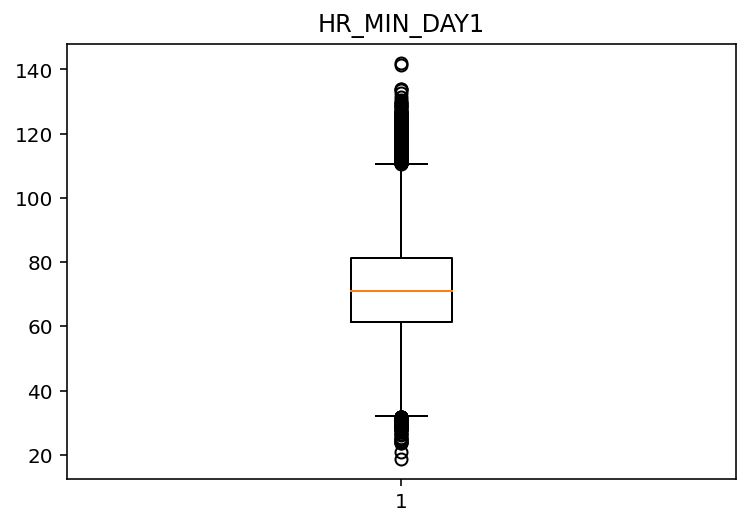

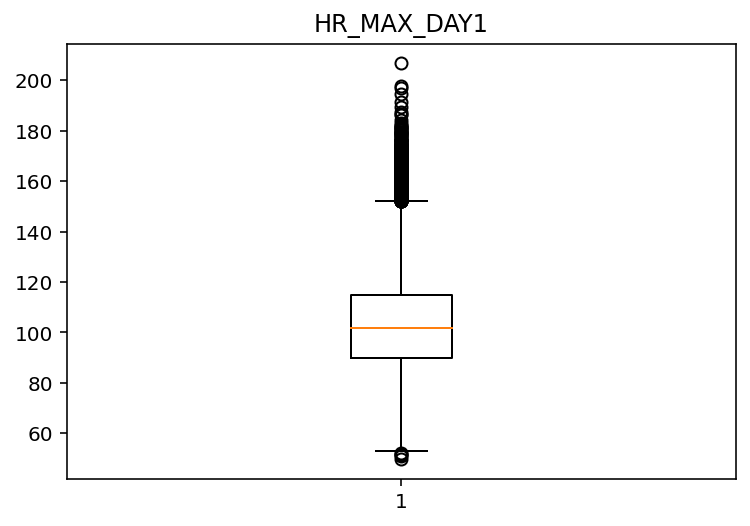

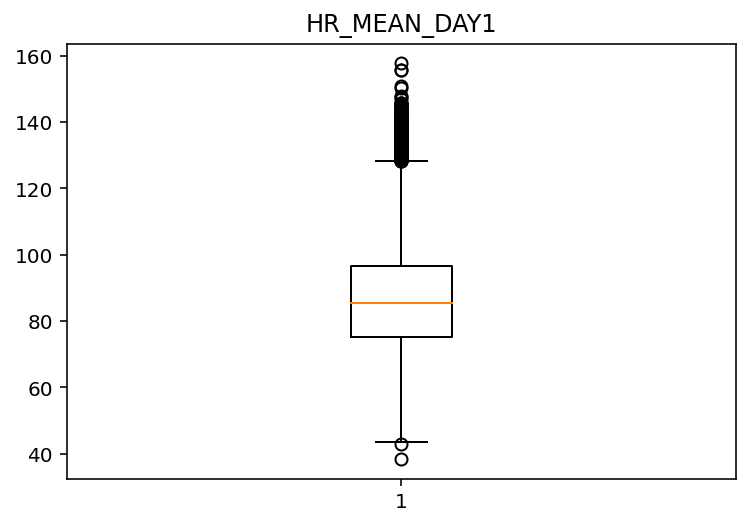

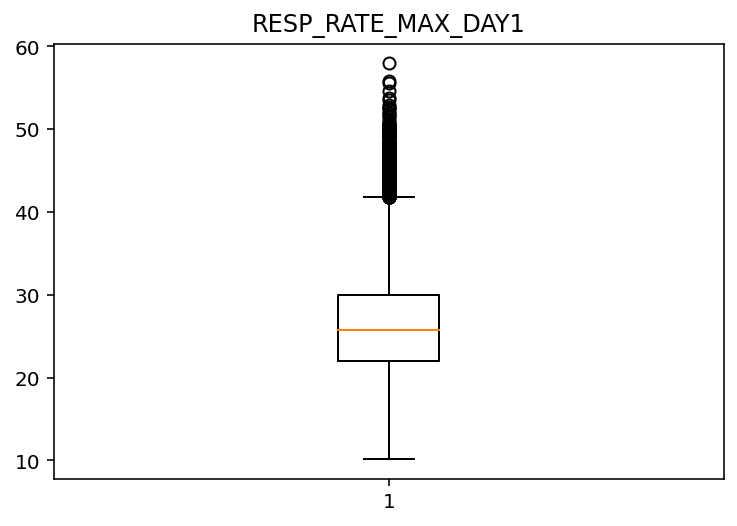

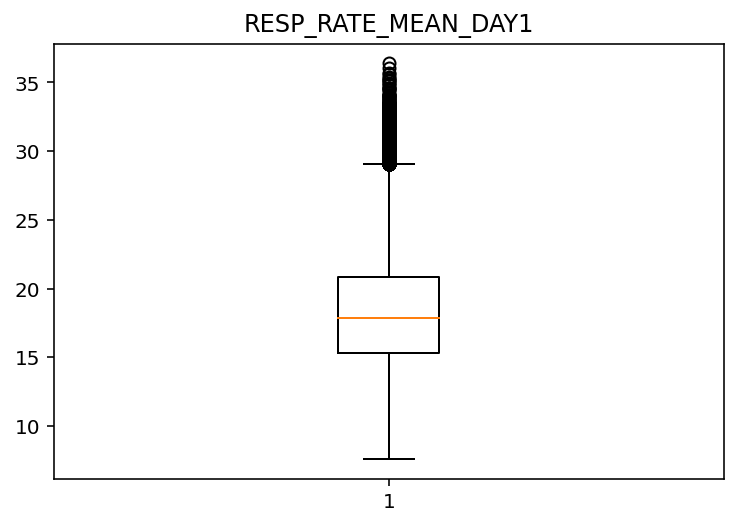

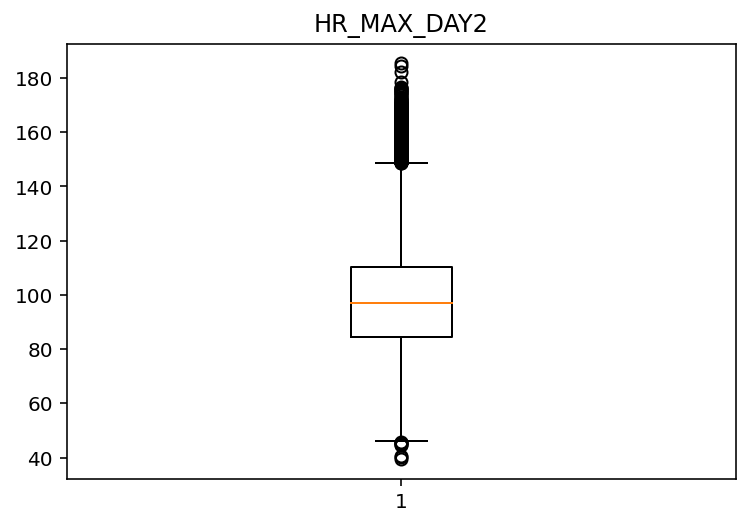

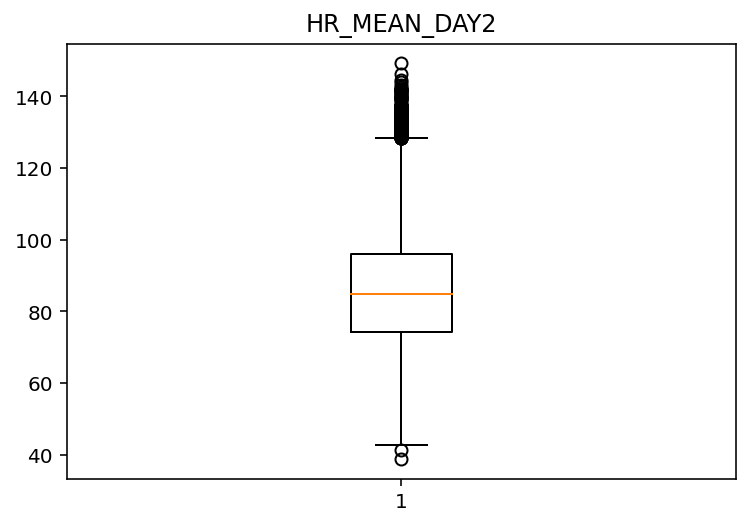

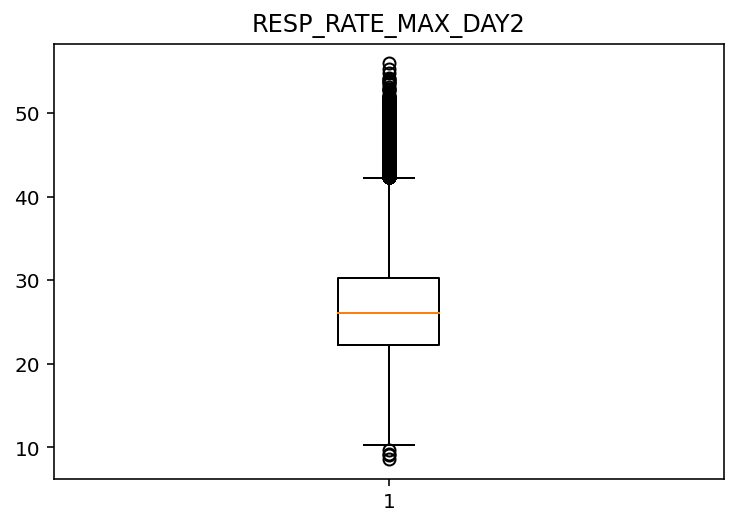

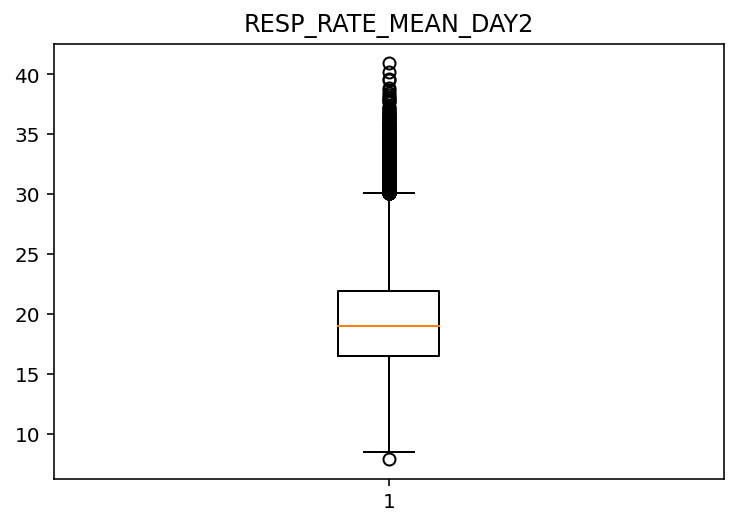

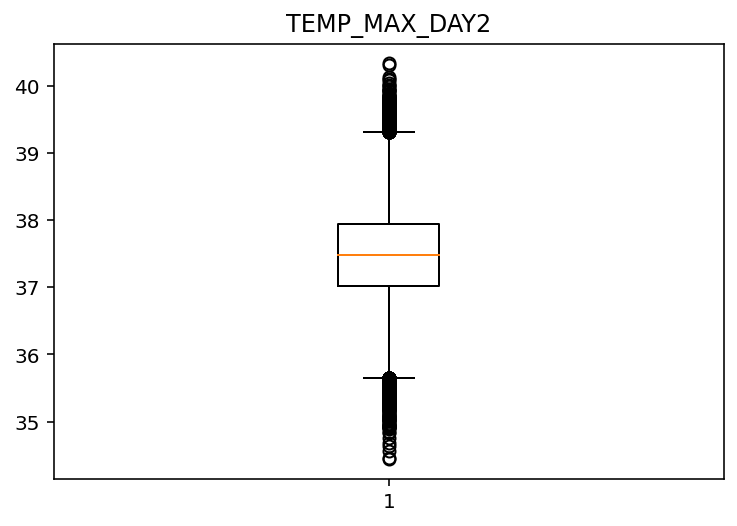

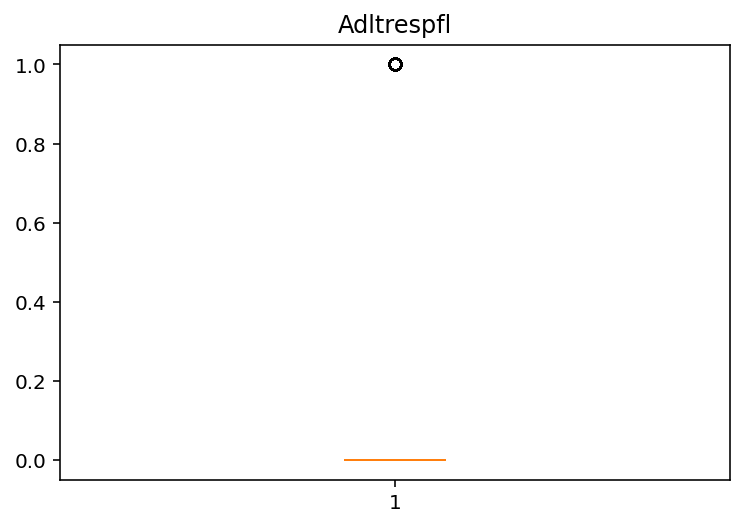

In [17]:
# TODO: Add graph

for i in variables_to_keep.index:
    if x_df[i].dtype.kind in 'biufc':
        fig1, ax1 = plt.subplots()
        ax1.set_title(i)
        ax1.boxplot(x_df[i])
    else:
        x_cnts = x_df[i].value_counts()
        x_cnts.plot.bar(rot=30)
        plt.show()
        

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

Premièrement nous observons une erreur d'encodage puisque 
Les variables Adltrespfl et Coag/hemrdx sont des variables catégorielles et non numériques puisque ce sont des variables dichotomiques.

On remarque des outliers dans les queue de distributions 

Par les noms des variables on en déduit qu'elles ont plus ou moins la même nature d'information 

On observe que HR_MIN_DAY1 à une médiane d'environ 70

On observe que HR_MAX_DAY1 à une médiane d'environ 100

On observe que RESP_RATE_MAX_DAY1 à une médiane d'environ 25

Le premier quartile de RESP_RATE_MAX_DAY2 est de environ 20

Le Troisième quartile de RESP_RATE_MAX_DAY2 est de environ 40


## 4. Pre-traitement

### Code : Traitement du problème des valeurs manquantes (ou non définies, NAN)

La solution la plus simple est d'éliminer l'ensemble des colonnes où il y a des données manquantes, mais on perd de l'information. 

Vu le faible nombre d'instances concernées (maximum 6 : voir ci-dessous) il parait plus pertinent de supprimer les lignes (instances) plutôt que les colonnes entières (variables).

La solution que nous choisissons ici est une troisième, celle de remplacer les valeurs non définies par la valeur la plus probable de la variable. Comme ces valeurs manquantes concernent exclusivement des variables catégorielles et binaires, la valeur la plus probable est le *mode* (voir cours : `part-5-slides.pdf`).

In [18]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


In [19]:
x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_miss

LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64

In [20]:
x_test_nans = x_test_df.isna().sum()
x_test_miss = x_test_nans[x_test_nans > 0]
x_test_miss

LANGUAGE                              2
ECodes:Adverseeffectsofmedicalcare    3
dtype: int64

In [21]:
x_miss_rows = x_df.isna().any(axis="columns")

x_df.loc[x_miss_rows, x_miss.index]

,LANGUAGE,MARITAL_STATUS,ICU,ECodes:Adverseeffectsofmedicalcare,Otnutritdx,Othnervdx
2251,ENGL,MARRIED,MICU,nan,0,0
9983,ENGL,MARRIED,MICU,0,nan,0
10549,ENGL,MARRIED,MICU,0,nan,0
10831,ENGL,MARRIED,MICU,nan,1,0
17012,ENGL,MARRIED,CSRU,nan,0,1
23088,ENGL,MARRIED,NaN,0,0,0
32539,ENGL,NaN,CSRU,0,0,0
42762,ENGL,SINGLE,TSICU,nan,0,0
53191,NaN,MARRIED,MICU,0,0,0
53390,CAPE,MARRIED,NaN,0,0,0


#### Remplacement des NAN

In [22]:
na_cols = set(x_miss.index) | set(x_test_miss.index)

for col in na_cols:
    x_df[col].fillna(x_df[col].mode()[0], inplace=True)
    x_test_df[col].fillna(x_test_df[col].mode()[0], inplace=True)

In [23]:
print(x_df.isna().any().any(), x_test_df.isna().any().any())

False False


In [24]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


### Domain Expertise

Simplifiez les données en regroupant par exemple les catégories rares.

In [25]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"


merge_rare_categories([x_df, x_test_df], col="RELIGION", keep_n=5)
print(x_test_df["RELIGION"].value_counts())

Index(['CATHOLIC', 'NOT_SPECIFIED', 'UNOBTAINABLE', 'PROTESTANT_QUAKER',
       'JEWISH'],
      dtype='object')
CATHOLIC             7517
NOT_SPECIFIED        3764
OTHER                2449
PROTESTANT_QUAKER    2208
UNOBTAINABLE         2208
JEWISH               1855
Name: RELIGION, dtype: int64


#### Code : Effectuez des regroupements de catégories rares pour d'autres variables si vous le jugez nécessaire

<span style="color:red">
    Répondre ci-dessous
</span>

In [26]:
# TODO: Other application of merge_rare_categories

merge_rare_categories([x_df, x_test_df], col="LANGUAGE", keep_n=2)
print(x_test_df["LANGUAGE"].value_counts())

Index(['ENGL', 'SPAN'], dtype='object')
ENGL     18883
OTHER      860
SPAN       258
Name: LANGUAGE, dtype: int64


### Transformation des données catégorielles en nombres entiers en utilisant deux types d'encodage

Les variables catégorielles sont présentées sous forme de chaines de caractères. La plupart des modèles ne pourront pas les prendre en entrée.

#### Encodage numérique simple

Deux des méthodes les plus simples sont `LabelEncoder` de Scikit-Learn et `factorize` de pandas. Elles consistent simplement à remplacer chaque nouvelle catégorie rencontrée par un entier, en commençant par 0. Ce n'est cependant peut-être pas la méthode la plus efficace, car elle présuppose une proximité entre les catégories codées avec des valeurs proches.

In [27]:
def label_encode(df, other_df, only_binary=False):

    char_cols = df.dtypes.pipe(lambda x: x[x == "object"]).index
    # print(char_cols)

    for col in char_cols:
        n_categories = len(x_df[col].unique())

        if not only_binary or n_categories == 2:
            codes, uniques = pd.factorize(df[col])
            df[col] = codes

            # Create conversion dic to convert values of test set as well
            cat2code = {k: v for v, k in enumerate(uniques)}
            other_df[col] = other_df[col].map(cat2code)

In [28]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0


In [29]:
print(x_df.shape, ys.shape)

(79999, 337) (79999,)


In [30]:
x_fact_df = x_df.copy()
x_test_fact_df = x_test_df.copy()

label_encode(x_fact_df, x_test_fact_df)

In [31]:
x_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,0,0,0,0,0,0,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,2,1,1,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0


In [32]:
x_test_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,3,0,5,3,0,0,18,72.64,112.7,96.46,...,0,0,0,0,0,0,0,0,0,0
1,2,0,2,1,4,0,56,66.61,106.8,83.85,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0,1,32,69.72,102.7,87.26,...,0,0,0,0,0,0,0,0,0,0


#### Encodage 1-Hot

Un autre type d'encodage est souvent plus efficace, il a notamment l'avantage de ne pas ordonner les classes d'une manière particulière (pas forcément en adéquation avec la proximité de ces classes entre elles).

Une méthode de pandas permet de le réaliser en 1 ligne de code avec la fonction `get_dummies`.

In [33]:
codes, uniques = pd.factorize(x_df["MARITAL_STATUS"])
cat2code = {k: v for v, k in enumerate(uniques)}
cat2code

{'DIVORCED': 0,
 'SINGLE': 1,
 'WIDOWED': 2,
 'MARRIED': 3,
 'UNKNOWN_(DEFAULT)': 4,
 'SEPARATED': 5,
 'LIFE_PARTNER': 6}

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

In [34]:
# Encode binary features on a single column (no need for 1-hot)
label_encode(x_df, x_test_df, only_binary=True)

x_all_1hot_df = pd.get_dummies(pd.concat([x_df, x_test_df]))

x_1hot_df = x_all_1hot_df.iloc[:len(x_df)].copy()
x_test_1hot_df = x_all_1hot_df.iloc[len(x_df):].copy()

print(x_df.shape, x_test_df.shape)
print(x_1hot_df.shape, x_test_1hot_df.shape)

(79999, 337) (20001, 337)
(79999, 398) (20001, 398)


#### Suppression des variables à valeur unique (constantes)

In [35]:
const_cols = {col for col in x_1hot_df if len(x_1hot_df[col].unique()) == 1}
len(const_cols)

173

In [36]:
x_1hot_df.drop(const_cols, axis="columns", inplace=True)
x_test_1hot_df.drop(const_cols, axis="columns", inplace=True)

print(x_1hot_df.shape, x_test_1hot_df.shape)

(79999, 225) (20001, 225)


### Création de l'ensemble de validation

In [37]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    x_1hot_df, ys, test_size=0.3
)
# VARS: x_df, x_fact_df, x_1hot_df

### Réduction de la dimension via l'ACP (PCA)

Testez l'ACP pour réduire le nombre de dimensions et observez si cela améliore le résultat.

Avant d'appliquer la ACP, il est conseillé de centrer-réduire les données (e.g., via `preprocessing.StandardScaler()`).

<span style="color:red">
    Répondre ci-dessous
</span>

In [38]:
# TODO: PCA

# mise à l'échelle

num_cols = x_df.columns[x_df.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

scaler = StandardScaler()

x_df[num_cols] = scaler.fit_transform(x_df[num_cols])

In [39]:
# PCA

pca = decomposition.PCA(n_components= 3)

X_PCA = pca.fit(x_df[num_cols]).transform(x_df[num_cols])

In [40]:
ex_variance=np.var(X_PCA,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio)

[0.431 0.323 0.247]


Proposez un graphique qui représente les 2 premières dimensions de la PCA et commentez succinctement.

<span style="color:red">
    Répondre ci-dessous
</span>

No handles with labels found to put in legend.


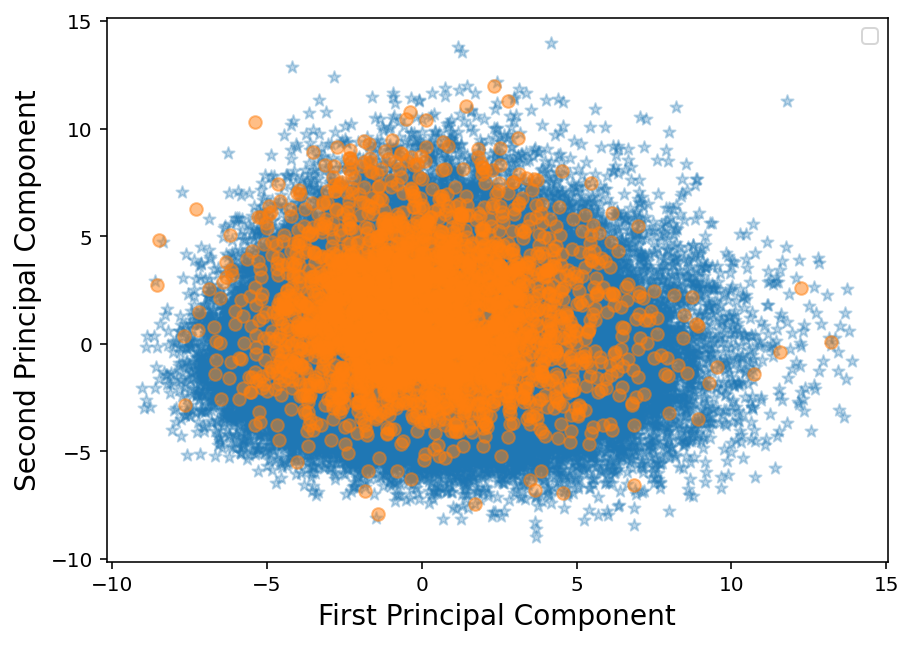

In [41]:
Xax=X_PCA[:,0]
Yax=X_PCA[:,1]
labels=ys
marker={0:'*',1:'o'}
alpha={0:.3, 1:.5}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
    ix=np.where(labels==l)
    ax.scatter(Xax[ix],Yax[ix],s=40,marker=marker[l],alpha=alpha[l])
    
# for loop ends
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.show()

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

La première composante explique 43% de la variance 

La seconde composante explique 32% de la variance 

La troisième composante explique 24% de la variance

Et la somme des 3 composantes donne 1

Sur le graphique avec la première et la seconde composante , nous n'observons pas grand chose , pas de tendance 

## 5. Modèles de classification

Entrainez le modèle

### Baseline

`LogisticRegression` or `RandomForestClassifier`

<span style="color:red">
    Répondre ci-dessous
</span>

In [42]:
# regression logistique
rlog = linear_model.LogisticRegression(max_iter=100)

# forêt aléatoire
rf1 = ensemble.RandomForestClassifier(n_estimators=2000, n_jobs = -1, random_state = 20, max_features = 0.2, max_depth = 3)
rf2 = ensemble.RandomForestClassifier(n_estimators=2000, n_jobs = -1, random_state = 20, max_features = 0.25, max_depth = 3)

# gradient boosting

gb1 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=20)
gb2 = GradientBoostingClassifier(n_estimators=300, learning_rate=0.2, max_depth=3, random_state=20)


In [43]:
models_name = [rlog, rf1, rf2, gb1, gb2] # ajouter les noms de modèles

## 6. Évaluations

### Code : Validation croisée

Le code ci-dessus utilise une méthode simple (*hold out*) pour mesurer le score de validation. Utilisez la validation croisée (pour obtenir une estimation plus fiable) combinée à l'exploration des hyperparamètres (pour améliorer les résultats).

Vous pouvez changer la valeur du nombre de validation croisée (CV) selon la valeur de l'erreur et le temps d'entrainement des modèles (compromis).

In [44]:
CV = 10
SCORING = "balanced_accuracy"

<span style="color:red">
    Répondre ci-dessous
</span>

In [45]:
# TODO: Cross-Validation
    
# evaluate a given model using cross-validation
def evaluate_model(model, CV):
    
    steps = [('scale', preprocessing.StandardScaler()), ('pca', decomposition.PCA(n_components=3)), ('classifier', i)] 
    pipeline = Pipeline(steps=steps)
    # prepare the cross-validation procedure
    cv = KFold(n_splits=CV, random_state=1, shuffle=True)
    # evaluate model
    scores = cross_val_score(pipeline, x_train, y_train, scoring= SCORING, cv=cv, n_jobs=3)
    # report performance
    print('Balanced accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))       
    return scores

for i in models_name:
    print(i)
    evaluate_model(i,5)


LogisticRegression()
Balanced accuracy: 0.500 (0.000)
RandomForestClassifier(max_depth=3, max_features=0.2, n_estimators=2000,
                       n_jobs=-1, random_state=20)
Balanced accuracy: 0.500 (0.000)
RandomForestClassifier(max_depth=3, max_features=0.25, n_estimators=2000,
                       n_jobs=-1, random_state=20)
Balanced accuracy: 0.500 (0.000)
GradientBoostingClassifier(learning_rate=1.0, random_state=20)
Balanced accuracy: 0.501 (0.002)
GradientBoostingClassifier(learning_rate=0.2, n_estimators=300, random_state=20)


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Balanced accuracy: 0.500 (0.001)


* **Pour 2 des modèles** (au moins 1 autre que les 2 proposés en baselines) :

    * Pour différentes valeurs d'un des hyperparamètres, donnez les `balanced_accuracy` moyennes de la validation croisée sous forme de Boxplots (ou de diagramme à bâtons avec une barre d'erreur) : voir l'exemple présenté dans le graphique ci-dessous. 
    
    * Explicitez succinctement quelles observations en tirer concernant la stabilité des prédictions.

![](img/boxplot-cv.png)

<span style="color:red">
    Répondre ci-dessous
</span>

Balanced accuracy: 0.501 (0.003)
Balanced accuracy: 0.500 (0.003)
Balanced accuracy: 0.499 (0.003)
Balanced accuracy: 0.501 (0.004)
Balanced accuracy: 0.501 (0.002)
Balanced accuracy: 0.501 (0.003)


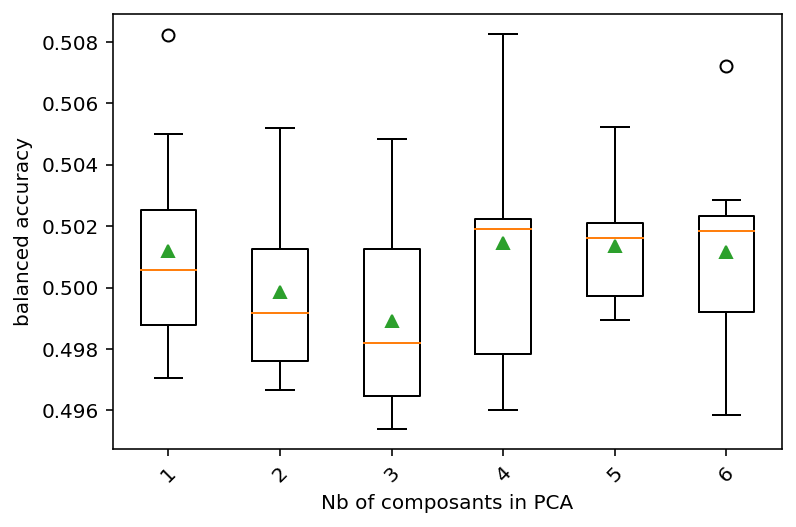

In [46]:
# TODO: Boxplot ou Barplot
 
# get a list of models to evaluate
def get_models(model):
    models = dict()
    for i in range(1,7):
        steps = [('pca', decomposition.PCA(n_components=i)), ('m', model)] #ajouter le modèle au choix
        models[str(i)] = Pipeline(steps=steps)
    return models
 

# get the models to evaluate
models = get_models(gb1)

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, 10)
    results.append(scores)
    names.append(name)
    
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=45)

# Add title and axis names
plt.xlabel('Nb of composants in PCA')
plt.ylabel('balanced accuracy')

plt.show()

/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Balanced accuracy: 0.502 (0.003)
Balanced accuracy: 0.500 (0.003)
Balanced accuracy: 0.501 (0.004)
Balanced accuracy: 0.500 (0.003)
Balanced accuracy: 0.501 (0.004)
Balanced accuracy: 0.500 (0.003)


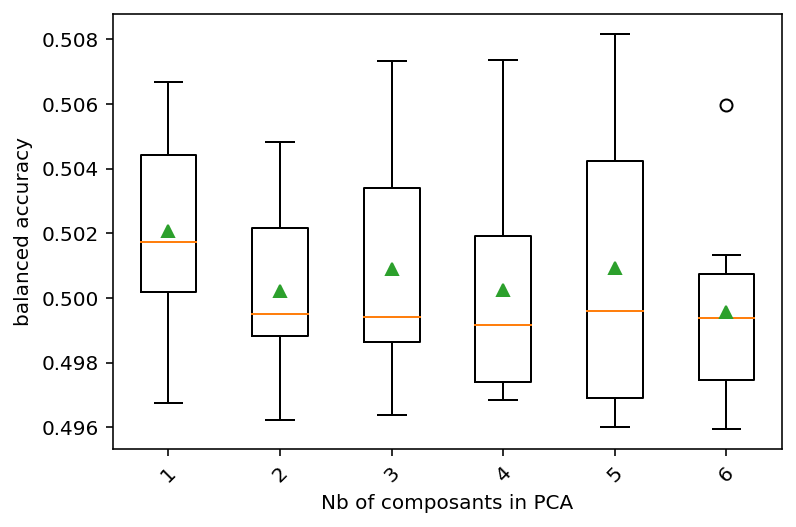

In [47]:
# TODO: Boxplot ou Barplot

# get the models to evaluate
models = get_models(gb2)

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, 10)
    results.append(scores)
    names.append(name)
    
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=45)

# Add title and axis names
plt.xlabel('Nb of composants in PCA')
plt.ylabel('balanced accuracy')

plt.show()

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

Pour le premier gradiant boosting , on observe pas vraiment de changement en terme de performence sur notre optimoseur quand on augmente le nombre de composante principal dans l'acp. On peux juste remarquer un écart type important entre fold quand on 5 axes dans notre ACP , mais en moyenne le score reste le même.

Pour le deuxième gradiait boosting on peut dire la même chose excepté quand le nombre d'axe est égal à 2.

En effet on observe de meilleur scores pour 2 fold.

* **Pour chacun de ces 2 modèles, à partir des données de validation créées précédemment** (`x_valid`, `y_valid`) :

    * Mesurez l'aire sous la courbe ROC (AUC) à l'aide de la fonction de Scikit-Learn (`roc_auc_score`) et comparez les modèles avec leur combinaison respective d'hyperparamètres offrant le meilleur résultat.

<span style="color:red">
    Répondre ci-dessous
</span>

In [48]:
# TODO: Confusion Mtx

def predict_class_and_probas(model):
    # define pipeline
    steps = [('scale', preprocessing.StandardScaler()), ('pca', decomposition.PCA(n_components=3)), ('m', model)] 
    pipeline = Pipeline(steps=steps)

    # evaluate pipeline
    y_pred = cross_val_predict(pipeline, x_valid, y_valid, cv=10, n_jobs=-1)
    y_proba = cross_val_predict(pipeline, x_valid, y_valid, cv=10, n_jobs=-1, method = 'predict_proba')
    return y_pred, y_proba

y_pred_gb1, y_proba_gb1 = predict_class_and_probas(gb1)
y_pred_gb2, y_proba_gb2 = predict_class_and_probas(gb2)

In [49]:
def confusion_matrix(y_pred):
    confusion_matrix = pd.crosstab(y_valid, y_pred, rownames=['Actual'], colnames=['Predicted'])
    return confusion_matrix

confusion_matrix(y_pred_gb1)

Predicted,0,1
Actual,,
0,22909,224
1,852,15


In [50]:
confusion_matrix(y_pred_gb2)

Predicted,0,1
Actual,,
0,22850,283
1,852,15


<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

Lecture : pour le 2eme modèle , on avons prédit 301 observations comme étant 1 alors qu'en réalité elles valent 0.

Nos matrices de confusions sont à l'image de notre score , qui est médiocre.

Nous observons peu d'observations en vrai positif. 

* **Pour le modèle et sa combinaison d'hyperparamètres offrant le meilleur résultat** :

    * Réalisez la matrice de confusion et décrivez-la succinctement.

<span style="color:red">
    Répondre ci-dessous
</span>

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.550


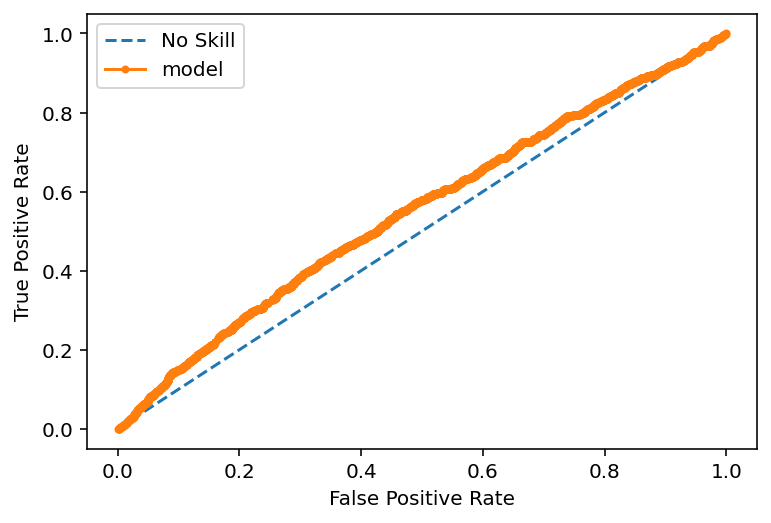

In [51]:
# TODO: ROC
def plot_roc_curve(y_proba):
    # keep probabilities for the positive outcome only
    lr_probs = y_proba[:, 1]

    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_valid))]

    # calculate scores
    ns_auc = roc_auc_score(y_valid, ns_probs)
    lr_auc = roc_auc_score(y_valid, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_valid, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_valid, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
plot_roc_curve(y_proba_gb1)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.619


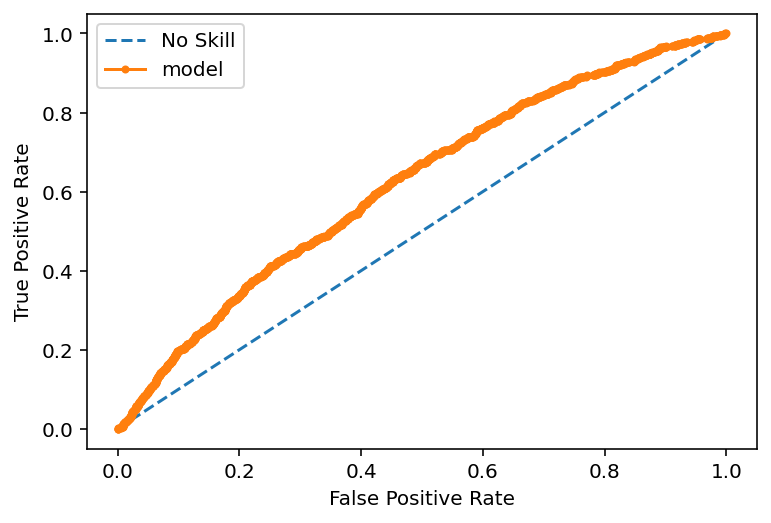

In [52]:
plot_roc_curve(y_proba_gb2)

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

La ligne bleue correspond à une prédiction si nous avions pas de modèle.

Notre modèle fait un peu mieux , en effet le premier gradiant boosting à une AUC de 0,56 et le 2eme de 0,61.

### Code : Essayez d'améliorer votre score

* Data augmentation (optionnel)

Vu le déséquilibre entre les classes à prédire (survive, died), on peut espérer améliorer le score en les rééquilibrant. Une approche typique est la génération de données (voir cours : `part-6-slides.pdf`). Une des méthodes de génération est [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE) (voir cours théorique), elle est notamment implémentée dans le module `imblearn`.

`imblearn` a été développé pour s'interfacer facilement avec `sklearn`.
Il propose notamment une version du `pipeline` qui permet l'intégration avec `sklearn`.

Ci-dessous voici un exemple de `pipeline` intégrant `imblearn` et `sklearn`.

<span style="color:red">
    Répondre ci-dessous
</span>

In [53]:
# TODO: Data augmentation

def data_augmentation(model):
    # define pipeline
    steps = [('scale', preprocessing.StandardScaler()), ('pca', decomposition.PCA(n_components=3)), ("resample", imblearn.over_sampling.SMOTE()), ('m', model)] 
    pipeline = Pipeline(steps=steps)

    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
    score = mean(scores)
    print(model)
    print('Balanced accuracy: %.3f (%.3f)' % (score, std(scores)))  

data_augmentation(gb1)
data_augmentation(gb2)

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE()' (type <class 'imblearn.over_sampling._smote.base.SMOTE'>) doesn't

### Explication de ce que vous avez réalisé, conclusion et perspectives

* Commencez par donner votre meilleur résultat obtenu lors de vos soumissions

* Expliquez le chemin qui vous y a conduit

    * Ce que vous avez essayé :

        * Ce qui a fonctionné

        * Ce qui n'a pas fonctionné et comment vous l'avez solutionné

    * Quelle méthode avez-vous utilisée pour choisir les hyperparamètres ?

    * Comparer la durée d'entrainement des principaux modèles utilisés ?

* Qu'auriez-vous fait si vous aviez eu plus de temps ?

<span style="color:red">
    Répondre ci-dessous
</span>

Notre meillleur résultat correspond à notre 2eme gradiant boosting avec une AUC de 0,61

Nous avons essayé plusieurs modèles et ce sont les gradiant boosting qui ont donné le meilleur résultat

Nous avons éssayé de jouer sur le nombre d'arbres et sur le learning rate.

Nous avons essayé de faire des arbres peu profond , car des arbres profonds peuvent entrainer un surapprentissage.

L'ACP n'a pas donné de si bon résultat (Cf : boxplot) nous avons donc essayé d'utiliser les algorithmiques (random forest et gradiant boosting comme levier de performance)

Pour choisir mes hyperparamètres , j'en ai testé plusieurs et j'ai choisi le modèle avec hyperparamètres qui donnent la balenced accuracy la plus élevée possible. 

Nous avons oublié de mesuré la durée d'entrainement , mais nous savons que la régression logistique à tourné le plus vite , la random forest a pu être parallélisé , mais le gradiant boosting et le modèle a pris le plus de temps à tourner.

Si j'avais eu plus de temps j'aurai tester plus de modèles et plus de hyperparamètres.

j'aurai également tester le SMOTE.

### Question (optionnelle)

* Qu'est-ce que le suréchantillonnage ? 

* En quoi pourrait-il être utile dans ce problème ?

<span style="color:red">
    Répondre ci-dessous
</span>

Le suréchantillonnnage est une méthode d'échantillonnage qui intervient lorsque la modélisation de données est déséquilibrées pendant la formation d'un modèle 

Le suréchntillonage aurait permis d'équilibrer les classes dans le cas où les classes sont très déséquilibrés. 

## 7. Enregistrer les prédictions

* Utilisez le code suivant pour faire des prédictions et pour les enregistrer sous forme de fichier ZIP
* Soumettez ce fichier ZIP sur [le site du challenge](https://competitions.codalab.org/competitions/30715#participate-submit_results)
("Participate > Submit/View Results > Submit")
* Faites de votre mieux pour être le ***premier sur le leaderboard !***

<span style="color:red">
    !! Ne pas oublier de modifier la commande de la prédiction selon les données et modèles choisis !!
</span>

* Données : `x_test_fact_df`, `x_test_1hot_df`

* Modèles : `model`, `search` (e.g., pour le `GridSearchCV`)

In [54]:
predictions = model.predict(x_test_1hot_df)  # compute predictions
# VARS: x_test_df, x_test_fact_df, x_test_1hot_df, x_test_1hot_pcs
# Models: model, search


PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")

NotFittedError: This PCA instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

---

# Remarque sur le jeu de données

Le jeu de données ne contient pas de données médicales réelles. Nous ne sommes pas autorisés à partager ces **données confidentielles** provenant de patient·e·s en soins intensifs. Pour éviter ce problème, les données ont été remplacées par des **données artificielles**.

Afin d'avoir des données crédibles, elles ont été générées à l'aide d'un réseau adverse génératif (**GAN**) Wasserstein.

Pour plus d'informations, voici une référence : <br />
[Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document) <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />

---